<a href="https://colab.research.google.com/github/Amazile/prevendo_as_vendas_de_uma_rede_de_farmacias/blob/main/Notebooks/Previs%C3%A3o_de_vendas_de_uma_rede_de_farm%C3%A1cias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A. Importação das bibliotecas

In [35]:
import numpy          as np

In [36]:
import pandas         as pd

In [37]:
import seaborn        as sns

In [38]:
import xgboost        as xgb

In [39]:
import datetime

In [40]:
import math

In [41]:
import random

In [42]:
import pickle

In [43]:
import requests

In [44]:
from scipy                  import stats 

In [45]:
from matplotlib             import pyplot as plt

In [46]:
import  matplotlib.gridspec  as  gridspec


In [47]:
from IPython.display        import Image

In [48]:
from IPython.core.display   import HTML

In [49]:
from sklearn.metrics        import  mean_absolute_error,mean_squared_error

In [50]:
from sklearn.ensemble       import RandomForestRegressor

In [51]:
from sklearn.linear_model   import LinearRegression,Lasso

In [52]:
from sklearn.preprocessing  import RobustScaler,MinMaxScaler,LabelEncoder

In [53]:
from tabulate import tabulate

In [54]:
import warnings

In [55]:
warnings.filterwarnings('ignore')

In [56]:
!pip install inflection

In [57]:
import inflection

In [58]:
!pip install boruta

In [59]:
from boruta import BorutaPy

# B. Funções auxiliares

In [60]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0])
       

In [61]:
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)


def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name' : model_name,
                        'MAE' : mae,
                        'MAPE' : mape,
                        'RMSE' : rmse}, index = [0])

In [62]:
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    chi2 = stats.chi2_contingency( cm )[0]
    n = cm.sum()
    r, k = cm.shape
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2/n)/ (min(kcorr-1,rcorr-1)))

In [63]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    jupyter_settings()

# C. Carregamento dos dados

In [64]:
df_sales_raw=pd.read_csv('/content/train.csv',low_memory=False)

In [65]:
df_store_raw=pd.read_csv('/content/store.csv',low_memory=False)

3.1.Junção dos dataframes

In [66]:
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

In [67]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
727315,6,2,2013-09-17,5448,742,1,0,0,0,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN


#Passo 1. Descrição dos dados

###1.1. Renomear colunas

In [68]:
df1 = df_raw.copy()

In [69]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [70]:
# Colunas copiadas do df original
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 
            'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

In [71]:
# Alterando o nome das colunas para minusculo e separados por _
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

In [72]:
# Renomeando as colunas
df1.columns = cols_new

In [73]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

###1.2. Quantidade do número de linhas e do número de colunas

In [74]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


###1.3. Tipos de dados

In [75]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [76]:
# Alterando a coluna 'date' para datime

df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

###1.4. Verificação de valores ausentes (NaN)

In [244]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

###1.5. Preenchimento de dados ausentes (NaN)

In [78]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
615125,431,5,2013-12-27,10098,1145,1,0,0,1,d,c,4520.0,NaN,NaN,0,NaN,NaN,NaN


In [79]:
df1['competition_distance'].max()

75860.0

In [80]:
#competition_distance              2642 dados ausentes
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

In [81]:
#competition_open_since_month    323348 dados ausentes
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) 
      else x['competition_open_since_month'], axis = 1 )

In [82]:
#competition_open_since_year     323348 dados ausentes
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) 
      else x['competition_open_since_year'], axis = 1 )


In [83]:
#promo2_since_week               508031 dados ausentes
df1['promo2_since_week']=df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week'])else x['promo2_since_week'],axis=1)

In [84]:
#promo2_since_year               508031 dados ausentes
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) 
      else x['promo2_since_year'], axis = 1 )

In [85]:
#promo_interval                  508031 dados ausentes
month_map = {
    1 : 'Jan',
    2 : 'Fev',
    3 : 'Mar',
    4 : 'Apr',
    5 : 'May',
    6 : 'Jun',
    7 : 'Jul',
    8 : 'Aug',
    9 : 'Sep',
    10 : 'Oct',
    11 : 'Nov',
    12 : 'Dec'}

In [86]:
df1['promo_interval'].fillna(0,inplace=True)

In [87]:
df1['month_map'] = df1['date'].dt.month.map(month_map)

In [88]:
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 
                                                             if x['promo_interval'] == 0 else 1  
                                                             if x['month_map'] in x['promo_interval'].split( ',' )  
                                                             else 0, axis=1 )

In [89]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

###1.6. Modificação dos tipos de dados

In [90]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [91]:
#Competition - Modificação do tipo de dado "float64" para "int"
df1['competition_open_since_month']=df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year']=df1['competition_open_since_year'].astype(int)

In [92]:
#Promo2 - Modificação do tipo de dado "float" para "int"
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [93]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

###1.7. Estatística descritiva

In [94]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

In [95]:
num_attributes.sample()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
676367,348,6,8761,773,1,0,0,16490.0,11,2013,1,22,2012,0


In [96]:
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64' ,'datetime64[ns]'])

In [97]:
cat_attributes.sample()

,state_holiday,store_type,assortment,promo_interval,month_map
72382,0,c,a,"Jan,Apr,Jul,Oct",May


####1.7.1 - Estatística descritiva: dados numéricos

In [98]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

In [99]:
# Dipersion - str, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

In [100]:
# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [101]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


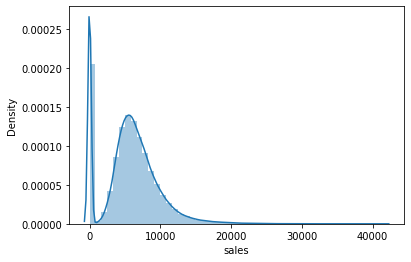

In [102]:
sns.distplot(df1['sales']);

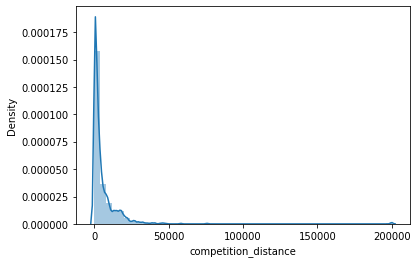

In [103]:
sns.distplot(df1['competition_distance']);

1.7.2 - Estatística descritiva: dados categóricos

In [104]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [105]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0 )];
plt.figure(figsize=(15, 7));

<Figure size 1080x504 with 0 Axes>

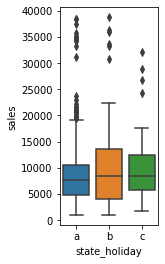

In [106]:
plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1);

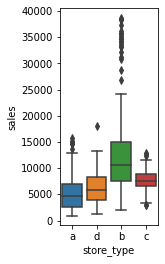

In [107]:
plt.subplot(1,3,2)
sns.boxplot(x = 'store_type',y = 'sales', data = aux1);

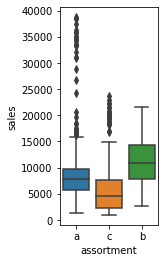

In [108]:
plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1);

# Passo 2. Engenharia de atributos (feature engineering)

In [109]:
df2 = df1.copy()

###2.1. Criação de hipóteses (brainstorming)

**Hipóteses referentes as lojas**
1. Lojas com mais funcionários: vendem mais.

2. Lojas com mais estoque: vendem mais.

3. Lojas com porte maior: vendem mais.

4. lojas com mais sortimento: vendem mais.

5. Lojas com competidores mais próximos: vendem menos.

6. Lojas com competidores a mais tempo: vendem menos.


**Hipóteses referentes aos produtos comercializados**
1. Lojas que investem mais em marketing: vendem mais.

2. Lojas que expõem mais produtos nas vitrines: vendem mais.

3. Lojas que têm preços menores: vendem mais.

4. Lojas com promoções mais agressivas (descontos maiores): vendem mais.

5. Lojas com promoções ativas por mais tempo: vendem mais.

6. Lojas com mais dias de promoção: vendem mais

7. Lojas com mais promoções consecutivas: vendem mais

**Hipóteses relacionadas ao tempo**
1. Lojas abertas no Natal: vendem mais.

2. Lojas vendem mais ao longo dos anos.

3. Lojas no segundo semestre do ano: vendem mais.

4. Lojas depois do dia 10 de cada mês: vendem mais.

5. Lojas abertas nos finais de semana: vendem menos.

6. Lojas durante feriados escolares: vendem menos.

**Seleção de hipóteses a partir das informações existentes**
1. Lojas com maior sortimento: vendem mais.

2. Lojas com competidores mais próximos: vendem menos.

3. Lojas com competidores a mais tempo: vendem mais.

4. Lojas com promoções ativas por mais tempo: vendem mais.

5. Lojas com mais promoções consecutivas: vendem mais.

6. Lojas abertas durante o feriado de natal: vendem mais.

7. Lojas ao longo dos anos: vendem mais.

8. Lojas no segundo semestre do ano: vendem mais.

9. Lojas depois do dia 10 de cada mês: vendem mais.

10. Lojas nos finais de semana: vendem menos.

11. Lojas durante os feriados escolares: vendem menos.

###2.2. Feature engineering

In [110]:
# year
df2['year'] = df2['date'].dt.year

In [111]:
#month
df2['month'] = df2['date'].dt.month

In [112]:
#day
df2['day'] = df2['date'].dt.day

In [113]:
# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

In [114]:
# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

In [115]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [116]:
#competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year =x['competition_open_since_year'] , 
                  month = x['competition_open_since_month'], day = 1), axis = 1)

In [117]:
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30 ).apply(lambda x: x.days).astype(int)

In [118]:
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)


In [119]:
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - 
                                              datetime.timedelta(days = 7))

In [120]:
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

In [121]:
#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

In [122]:
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' 
                                                  if x == 'a' else 'easter_holiday'
                                                  if x == 'b' else 'christimas' 
                                                  if x == 'c' else 'regular_day')

In [123]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


#Passo 3. Filtragem de variáveis

Filtragem de variáveis: de acordo com o time de negócios as variáveis serão filtradas.

In [124]:
df3 = df2.copy()

In [125]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


###3.1. Filtragem das linhas

In [126]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

###3.2. Seleção das colunas

In [127]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [128]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# Passo 4 - Análise exploratória dos dados

In [129]:
df4=df3.copy()
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


###4.1. Análise univariada

####4.1.1. Variável resposta (response variable)

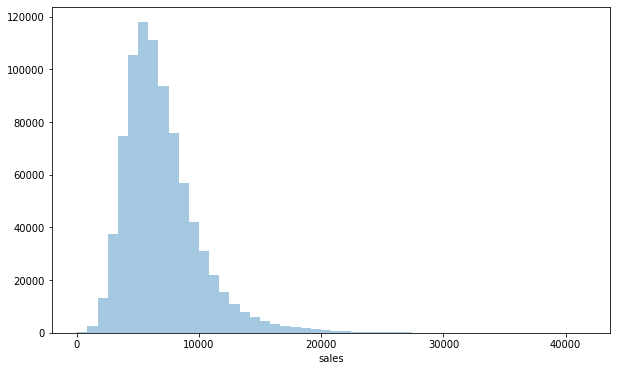

In [130]:
plt.figure(figsize=(10, 6))
sns.distplot (df4 ['sales'], kde = False);

####4.1.2. Variáveis numéricas

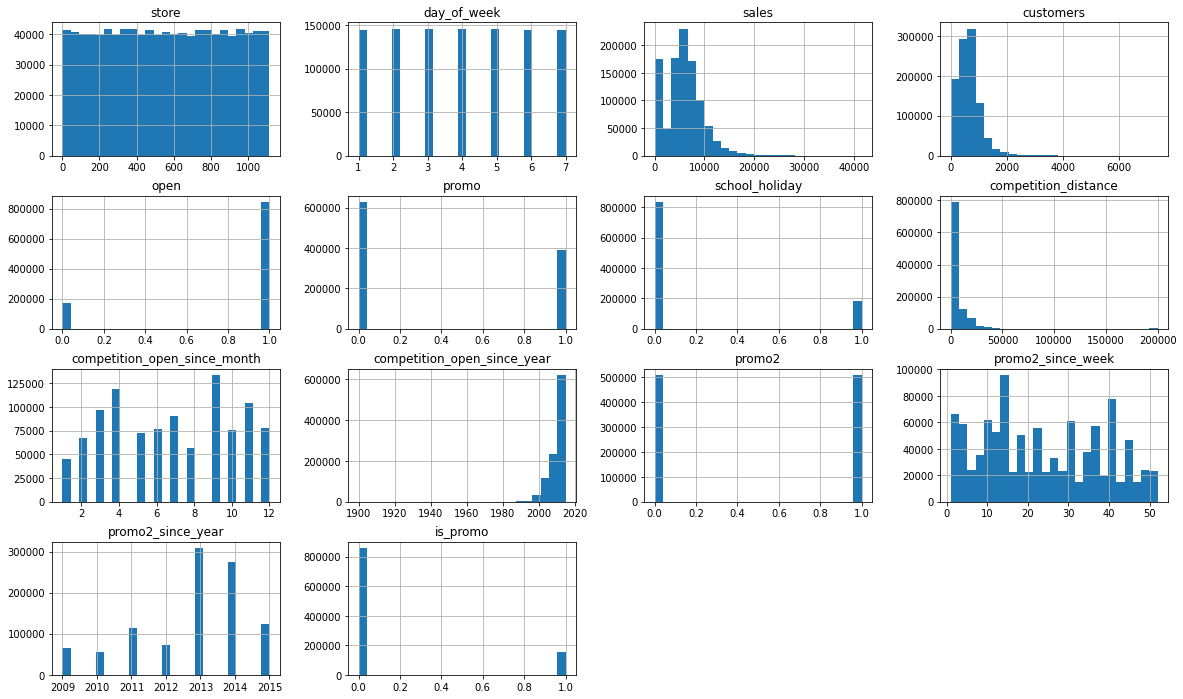

In [131]:
num_attributes.hist(bins = 25,figsize=(20,12));

####4.1.3. Variáveis categóricas

In [132]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126        christimas
Name: state_holiday, dtype: object

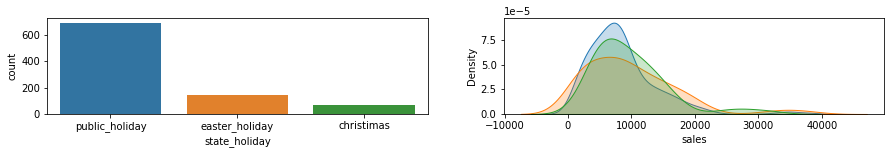

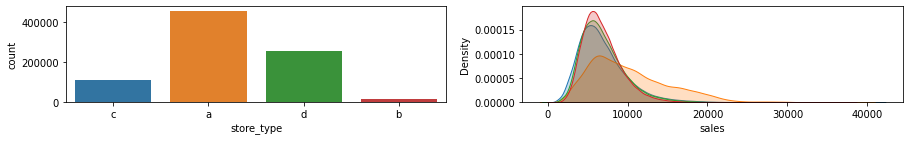

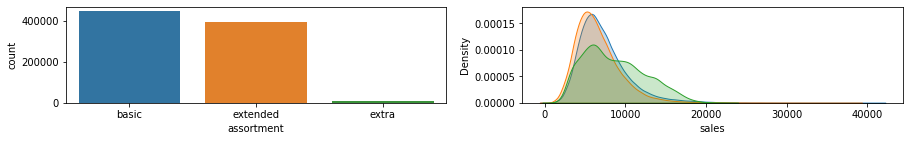

In [133]:
# State holiday
plt.figure(figsize=(15,6))
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christimas']['sales'], label = 'christimas', shade = True)

#store type
plt.figure(figsize=(15,6))
plt.subplot(3, 2, 3)
a = df4[df4['store_type'] != 'regular_day']
sns.countplot(a['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade = True)

# Assortment
plt.figure(figsize=(15,6))
plt.subplot(3, 2, 5)
a = df4[df4['assortment'] != 'regular_day']
sns.countplot(a['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True);

###4.2 Análise bivariada

**Seleção de hipóteses a partir das informações existentes**
1. Lojas com maior sortimento: vendem mais.

2. Lojas com competidores mais próximos: vendem menos.

3. Lojas com competidores a mais tempo: vendem mais.

4. Lojas com promoções ativas por mais tempo: vendem mais.

5. Lojas com mais promoções consecutivas: vendem mais.

6. Lojas abertas durante o feriado de natal: vendem mais.

7. Lojas ao longo dos anos: vendem mais.

8. Lojas no segundo semestre do ano: vendem mais.

9. Lojas depois do dia 10 de cada mês: vendem mais.

10. Lojas nos finais de semana: vendem menos.

11. Lojas durante os feriados escolares: vendem mais.

**Hipótese 1 - Lojas com maior sortimento: vendem mais.**

A partir dos dados abaixo observa-se que:
- a **HIPÓTESE 1 É FALSA** porque:LOJAS com MAIOR SORTIMENTO VENDEM MENOS.

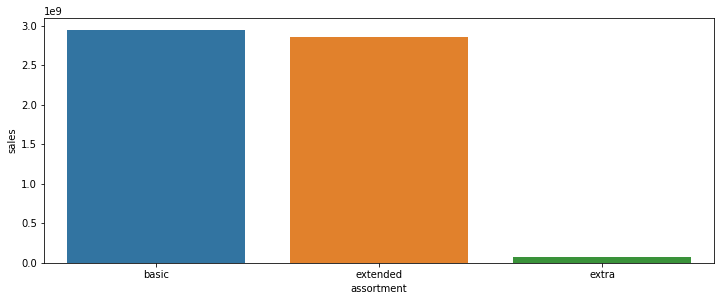

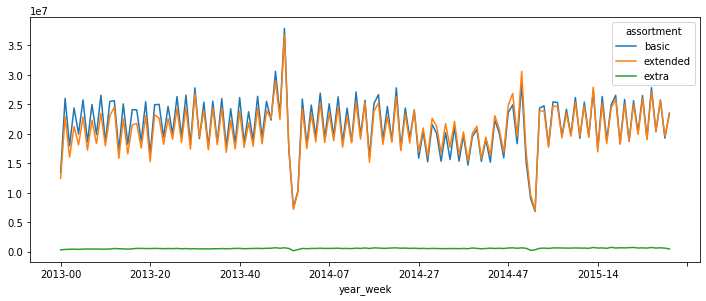

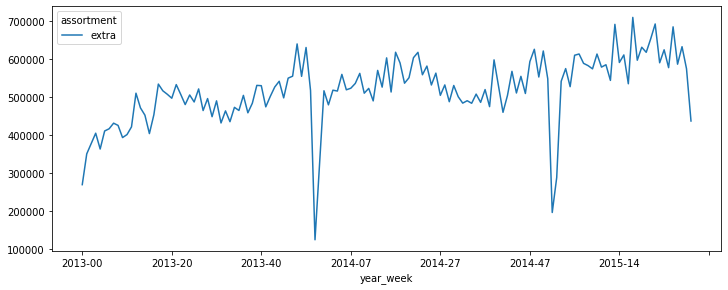

In [134]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
plt.figure(figsize=(12,4.5))
sns.barplot(x='assortment', y='sales', data = aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot(figsize=(12, 4.5))

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'year_week', columns ='assortment', values = 'sales').plot(figsize=(12, 4.5));

**Hipótese 2 - Lojas com competidores mais próximos: vendem menos.**

A partir dos dados abaixo observa-se que: 
- a **HIPÓTESE 2 é FALSA** porque: LOJAS com COMPETIDORES MAIS PRÓXIMOS VENDEM MAIS.

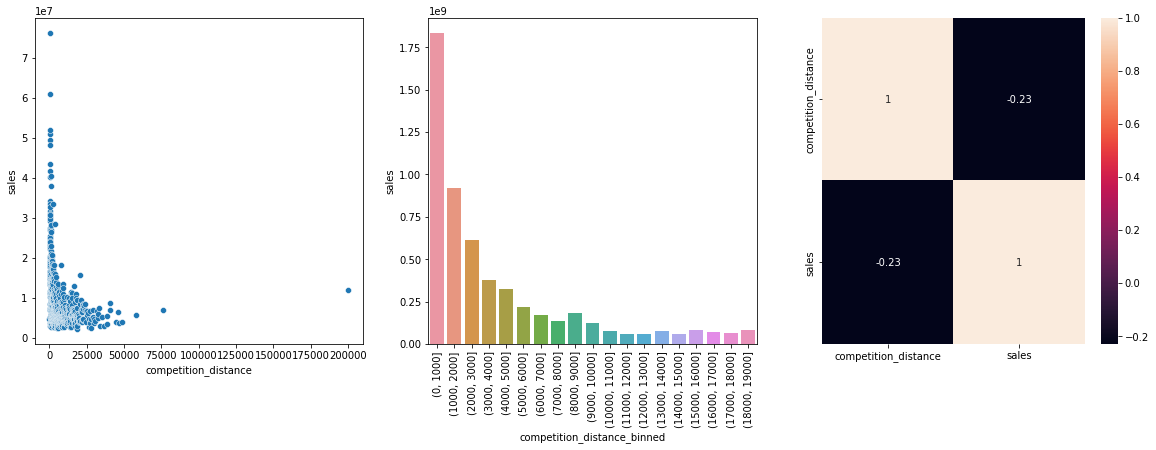

In [135]:
plt.figure(figsize=(20, 6))
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(1, 3, 1)
sns.scatterplot(x = 'competition_distance', y='sales', data = aux1)


plt.subplot(1, 3, 2)

bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
plt.xticks(rotation = 90)

# Somando as vendas de acordo com os bins
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

sns.barplot(x='competition_distance_binned', y='sales', data = aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot = True);

**Hipótese 3 - Lojas com competidores a mais tempo: vendem mais.**

A partir dos dados abaixo observa-se que:
- a **HIPÓTESE 3 é FALSA** porque LOJAS com COMPETIDORES A MAIS TEMPO: VENDEM MENOS.

(2.5, -0.5)

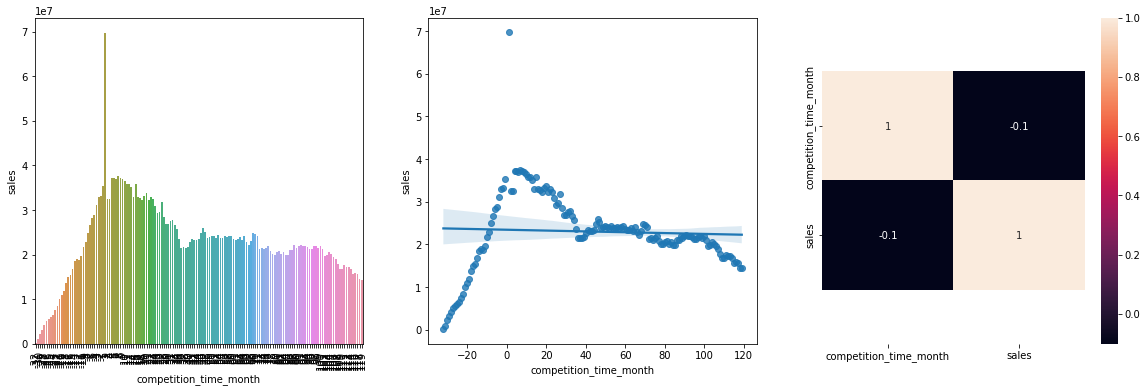

In [136]:
plt.figure(figsize=(20,6))
plt.subplot(1, 3, 1)

aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data = aux2)

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method = 'pearson'), annot = True)
bottom, top = x.get_ylim()
x.set_ylim(bottom + 0.5, top - 0.5)

**Hipótese 4- Lojas com promoções ativas por mais tempo: vendem mais.**

A partir dos dados abaixo observa-se que:
- a **HIPÓTESE 4 é FALSA** porque LOJAS com PROMOÇÕES ATIVAS POR MAIS TEMPO: VENDEM MENOS, depos de um certo período de promoção.

In [137]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

In [138]:
grid = gridspec.GridSpec(2, 3)

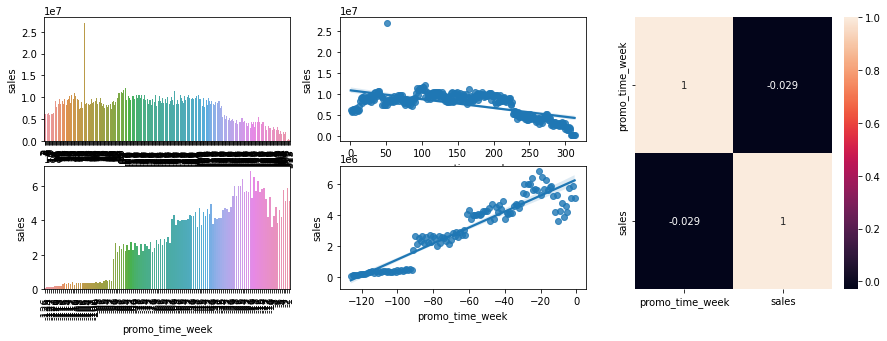

In [139]:
plt.figure(figsize=(15,5))

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

**Hipótese 5 - Lojas com mais promoções consecutivas: vendem mais.**

Considerando-se os dados abaixo observa-se que:
- a **HIPÓTESE 5 é FALSA** porque LOJAS com MAIS PROMOÇÕES CONSECUTIVAS: VENDEM MENOS.

In [140]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()


,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


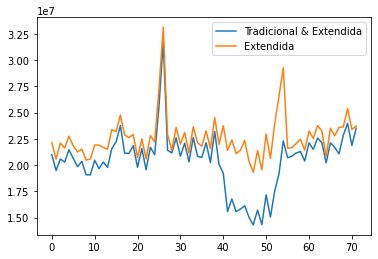

In [141]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

**Hipótese 6 - Lojas abertas durante o feriado de natal: vendem mais.**

Considerando os dados abaixoque se seguem observa-se que:

- a **HIPÓTESE 6 é FALSA** porque LOJAS com ABERTAS DURANTE O NATAL: VENDEM MENOS.

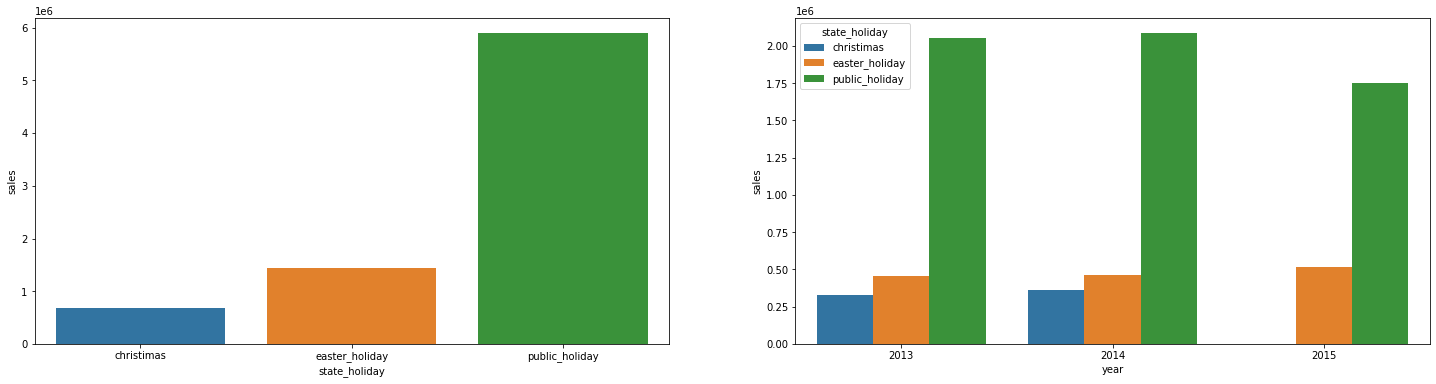

In [142]:
 aux = df4[df4['state_holiday'] != 'regular_day']
 plt.figure(figsize =(25, 6))

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );


**Hipótese 7 - Lojas ao longo dos anos: vendem mais.**

Considerando os dados abaixo que se seguem observa-se que:

- a **HIPÓTESE 7 é FALSA** porque LOJAS AO LONGO DOS ANOS: VENDEM MENOS.

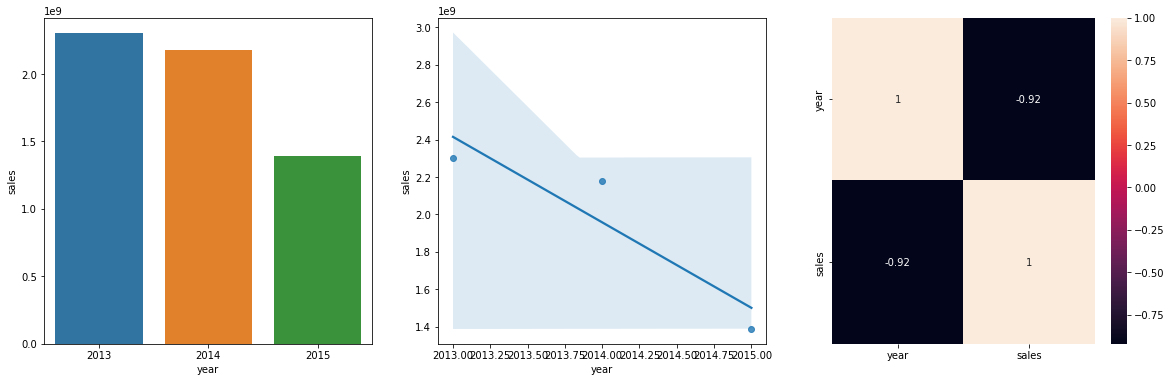

In [143]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
plt.figure(figsize =(20, 6))

plt.subplot(1, 3, 1)
sns.barplot(x = 'year', y = 'sales', data = aux1)


plt.subplot(1, 3, 2)
sns.regplot(x = 'year', y = 'sales', data = aux1);


plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

**Hipótese 8 - Lojas no segundo semestre do ano: vendem mais.**
Considerando os dados que se seguem observa-se que:
- a **HIPÓTESE 7 é FALSA** porque LOJAS NO SEGUNDO SEMESTRE DO ANO: VENDEM MENOS.

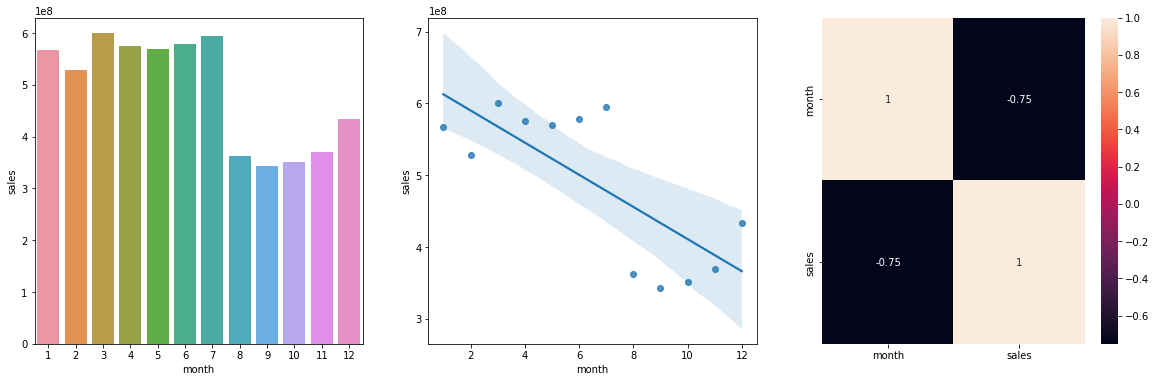

In [144]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()
plt.figure(figsize =(20, 6))

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

**Hipótese 9 - Lojas depois do dia 10 de cada mês: vendem mais.**
 Considerando os dados que se seguem observa-se que:

- a **HIPÓTESE 9 é VERDADEIRA** porque LOJAS DEPOIS do dia 10 DE CADA MÊS: VENDEM MAIS

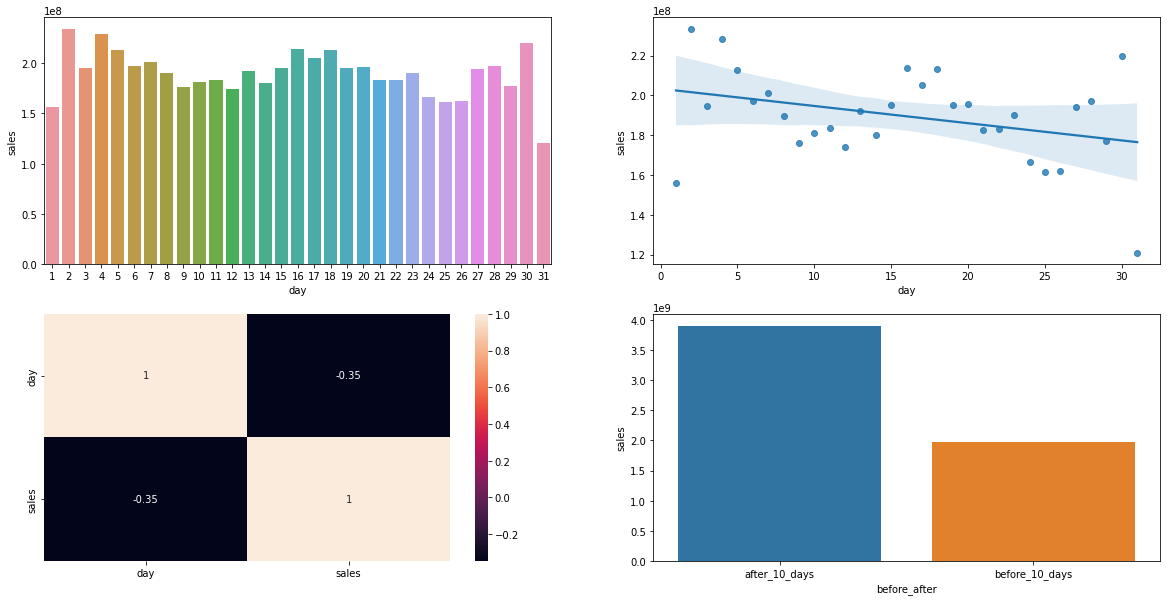

In [145]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
plt.figure(figsize =(20, 10))

plt.subplot(2, 2, 1)
sns.barplot(x = 'day', y = 'sales', data = aux1)


plt.subplot(2, 2, 2)
sns.regplot(x = 'day', y = 'sales', data = aux1);


plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

plt.subplot(2, 2, 4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y = 'sales', data = aux2);

**Hipótese 10 - Lojas nos finais de semana: vendem menos.**
 Considerando os dados que se seguem observa-se que:

- a **HIPÓTESE 10 é VERDADEIRA** porque lojas nos finais de semana vendem menos.

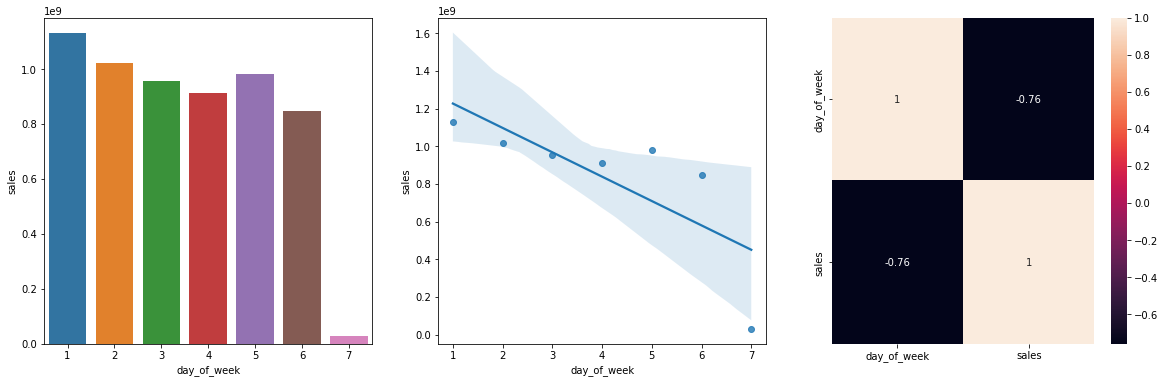

In [146]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
plt.figure(figsize =(20, 6))

plt.subplot(1, 3, 1)
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1)


plt.subplot(1, 3, 2)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux1);


plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

**Hipótese 11 - Lojas durante os feriados escolares: vendem menos.**
 Considerando os dados que se seguem observa-se que:

- a **HIPÓTESE 11 é VERDADEIRA** porque lojas nos feriados escolares vendem menos, excluindo nos feriados de julho e agosto.

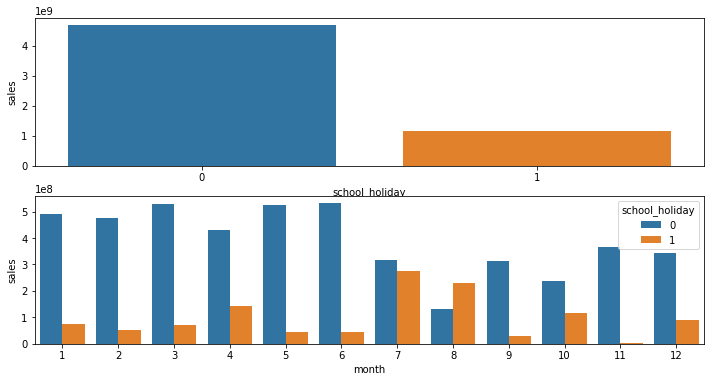

In [147]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.figure(figsize=(12,6))

plt.subplot(2, 1, 1)
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1)

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2, 1, 2)
sns.barplot(x = 'month', y = 'sales', data = aux2, hue = 'school_holiday');

In [148]:
#Resumo das hipóteses
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


###4.3. Análise multivariada

####4.3.1. Atributos numéricos

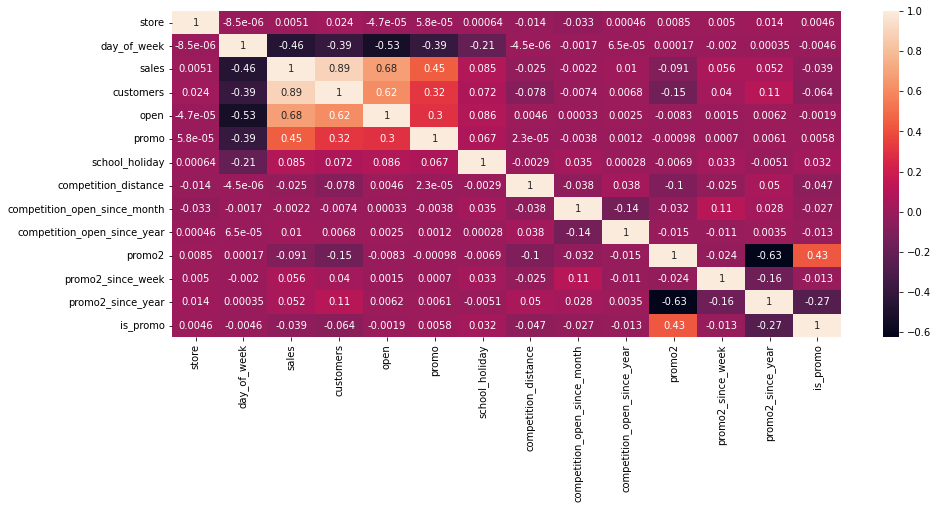

In [149]:
correlation = num_attributes.corr(method = 'pearson')

plt.figure(figsize=(15, 6))
sns.heatmap(correlation, annot = True);

####4.3.2. Atributos categóricos

In [150]:
#apenas dados categóricos
a = df4.select_dtypes(include = 'object')
a.head(2)

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30


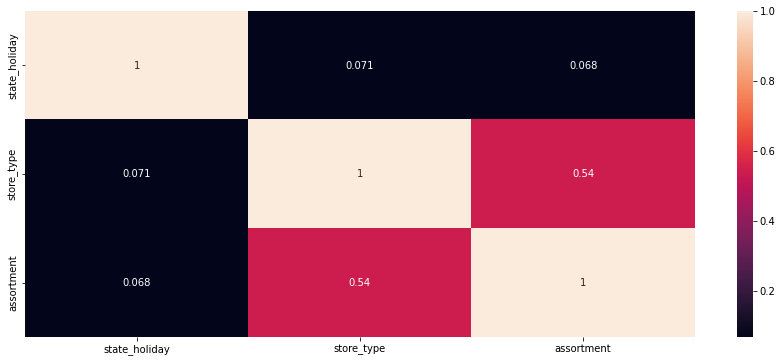

In [151]:
# only categorical data
a = df4.select_dtypes( include='object' )
# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
'store_type': [a4, a5, a6],
'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )

plt.figure(figsize=(15, 6))
sns.heatmap( d, annot=True );

# Passo 5 - Preparação dos dados

In [152]:
df5=df4.copy()

In [153]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


###5.1. Normalização: nenhuma das variáveis numéricas apresenta distribuição normal.

###5.2. Rescaling

In [154]:
# Selecionando as variaveis numericas
a = df5.select_dtypes(include=['float64', 'int64'])

In [155]:
# Visualizando 
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


In [156]:
# Aplicados os rescaling: 'min-max scaler' e 'Robust Scaler'
# Critério para definição: se existem outliers ou não
# Variáveis: competition distance, year, competition time month, promo time week

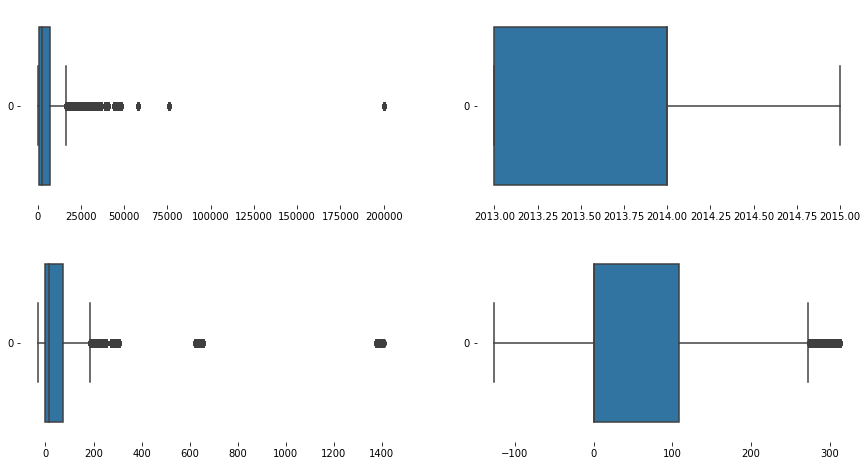

In [157]:
plt.figure(figsize=(15,8))

plt.subplot(2, 2, 1)
sns.boxplot(data = df5['competition_distance'], orient = 'h')

plt.subplot(2, 2, 2)
sns.boxplot(data = df5['year'], orient = 'h')

plt.subplot(2, 2, 3)
sns.boxplot(data = df5['competition_time_month'], orient = 'h')

plt.subplot(2, 2, 4)
sns.boxplot(data = df5['promo_time_week'], orient = 'h')

sns.despine(bottom=True, left = True);

In [158]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

#year
df5['year'] = mms.fit_transform(df5[['year']].values)

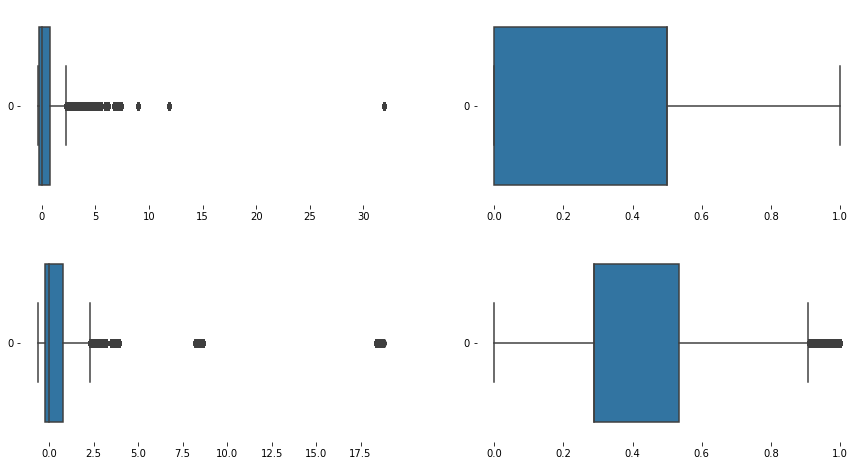

In [159]:
plt.figure(figsize=(15, 8))

#competition_distance
plt.subplot(2, 2, 1)
sns.boxplot(data = df5['competition_distance'], orient = 'h')

#year
plt.subplot(2, 2, 2)
sns.boxplot(data = df5['year'], orient = 'h')

#competition_time_month
plt.subplot(2, 2, 3)
sns.boxplot(data = df5['competition_time_month'], orient = 'h')

#promo_time_week
plt.subplot(2, 2, 4)
sns.boxplot(data = df5['promo_time_week'], orient = 'h')

sns.despine(bottom=True, left = True);

###5.3. Transformação

####5.3.1. Encoding 

In [160]:
#state_holiday - one hot encoding
df3 = pd.get_dummies(df3, prefix =['state_holiday'], columns = ['state_holiday'])

In [161]:
# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
#pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

In [162]:
# assortment - Ordinal Encoding
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

####5.3.2.Transformação de variável de resposta (response variable transformation)

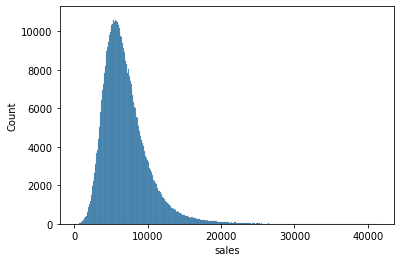

In [163]:
sns.histplot(df5['sales']);

In [164]:
# Transformacao logarítmica
df5['sales'] = np.log1p(df5['sales'])

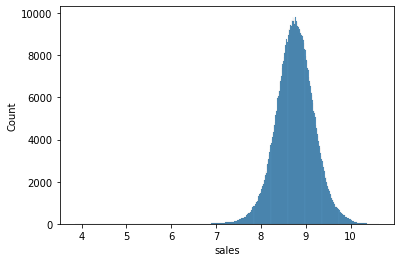

In [165]:
sns.histplot(df5['sales']);

####5.3.3. Nature transformation

In [166]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x* (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x* (2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x* (2. * np.pi/30)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x* (2. * np.pi/30)))

# day
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x* (2. * np.pi/30)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x* (2. * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x* (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x* (2. * np.pi/52)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin (x * ( 2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.sin (x * ( 2. * np.pi/30)))

#Passo 6 - Seleção de features

In [167]:
df6=df5.copy()

###6.1. Divisão do dataframe em treinamento e conjunto de dados de teste

In [168]:
# colunas que serão deletadas
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']

In [169]:
# excluindo as colunas do dataframe
df6 = df6.drop(cols_drop, axis = 1)

In [170]:
# Buscando a menor data de cada loja
df6[['store', 'date']].groupby('store', as_index = False).min()

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
...,...,...
1110,1111,2013-01-02
1111,1112,2013-01-02
1112,1113,2013-01-02
1113,1114,2013-01-02


In [171]:
# Buscando a maior data de cada loja
df6[['store', 'date']].groupby('store', as_index = False).max()

,store,date
0,1,2015-07-31
1,2,2015-07-31
2,3,2015-07-31
3,4,2015-07-31
4,5,2015-07-31
...,...,...
1110,1111,2015-07-31
1111,1112,2015-07-31
1112,1113,2015-07-31
1113,1114,2015-07-31


In [172]:
# subtraindo 42 dias da ultima data que consta no dataset
df6[['store', 'date']].groupby('store', as_index = False).max()['date'][0] - datetime.timedelta(days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [173]:
# Separando os dados de treino
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# Separando os dados de teste
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Min Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Min Date: 2015-07-31 00:00:00


###6.2. Boruta como selecionador de features (Boruta as Feature Selector)

In [174]:
# training and test dataset for Boruta
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel()

# define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

####6.2.1. Best features from Boruta

In [175]:
#cols_selected = boruta.support_.tolist()

#Best Features
#X_train_fs = X.train.drop(['date', 'sales'], axis = 1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# nota selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_select_boruta))

In [176]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

#cols_selected_boruta_full = cols_selected_boruta.copy()
#cols_selected_boruta_full.extend( feat_to_add )

#Passo 7 - Machine Learning Modelling

In [177]:
# Criando variáveis e selecionando somente as colunas consideradas importantes
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

###7.1. Average model

In [178]:
# Fazendo uma cópia do x_test
aux1 = x_test.copy()

# Inserindo a coluna sales 
aux1['sales'] = y_test.copy()

# Prediction
aux2 = aux1[['store', 'sales']].groupby('store', as_index = False).mean().rename(columns={'sales' : 'predictions'})

# Fazendo merge dos dois dataframes
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store')

# Variavel previsao
yhat_baseline = aux1['predictions']

# Performance (exponencial: as variaveis preditoras foram transformadas nos passos anteriores)
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


###7.2. Linear regression model

In [179]:
# model
lr = LinearRegression().fit(x_train, y_train)

# Prediction
yhat_lr = lr.predict(x_test)

# Performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1874.090263,0.287976,2703.216075


In [180]:
# Adicionando as colunas consideradas como importante em uma nova variável
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [181]:
# criando uma variavel com todas as colunas (consideradas importante + preditoras)
x_training = X_train[cols_selected_boruta_full]

####7.2.1. Linear regression model - cross validation

In [182]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose = False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2035.02 +/- 248.55,0.3 +/- 0.01,2896.39 +/- 364.24


###7.3. Linear regression regularized model - Lasso

In [183]:
# model
lrr = Lasso(alpha = 0.01).fit(x_train, y_train)

# Prediction
yhat_lrr = lrr.predict(x_test)

# Performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1906.749337,0.290735,2765.854437


####7.3.1. Lasso - cross validation

In [184]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose = False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2131.09 +/- 342.41,0.29 +/- 0.01,3077.55 +/- 506.01


###7.4. Random forest regressor

In [185]:
# model
rf = RandomForestRegressor(n_estimators = 100, n_jobs = 1, random_state = 42).fit(x_train, y_train)

# Prediction
yhat_rf = rf.predict(x_test)

# Performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,655.64076,0.096916,972.058195


###7.4.1. Random forest regressor - cross validation

In [186]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,851.93 +/- 211.64,0.12 +/- 0.02,1258.58 +/- 307.99


###7.5. XGBoost regressor

In [187]:
# model
model_xgb = xgb.XGBRegressor(objetive = 'reg:squarederror',
                            n_estimators = 100,
                            eta = 0.01,
                            max_depth = 10,
                            subsample = 0.7,
                            colsample_bytee = 0.9).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# Performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

[19:38:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,869.1064,0.124387,1288.375092


###7.5.1. XGBoost regressor - cross validation

In [188]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)



KFold Number: 5
[19:42:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

KFold Number: 4
[19:45:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

KFold Number: 3
[19:48:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

KFold Number: 2
[19:52:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

KFold Number: 1
[19:56:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [189]:
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1033.84 +/- 163.84,0.14 +/- 0.01,1495.84 +/- 254.68


###7.6. Compare model's performance

###7.6.1 Single performance

In [190]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result,rf_result, xgb_result] )

In [191]:
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,655.640760,0.096916,972.058195
0,XGBoost Regressor,869.106400,0.124387,1288.375092
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1874.090263,0.287976,2703.216075
0,Linear Regression - Lasso,1906.749337,0.290735,2765.854437


###7.6.2 Real performance - cross validation

In [192]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv,xgb_result_cv] )

In [193]:
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2035.02 +/- 248.55,0.3 +/- 0.01,2896.39 +/- 364.24
0,Lasso,2131.09 +/- 342.41,0.29 +/- 0.01,3077.55 +/- 506.01
0,Random Forest Regressor,851.93 +/- 211.64,0.12 +/- 0.02,1258.58 +/- 307.99
0,XGBoost Regressor,1033.84 +/- 163.84,0.14 +/- 0.01,1495.84 +/- 254.68


In [221]:
#XGBoost Regressor selecionado: custo/benefício da implementação

#Passo 8 - Hyperparameter fine tunning

###8.1. Random search

In [195]:
param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],'eta': [0.01, 0.03],'max_depth': [3, 5, 9],'subsample': [0.1, 0.5, 0.7],
        'colsample_bytree': [0.3, 0.7, 0.9],'min_child_weight': [3, 8, 15]}

MAX_EVAL = 5

In [196]:
#final_result = pd.DataFrame()

#for i in range( MAX_EVAL ):
#
# choose values for parameters randomly
# hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
# print( hp )
#
# # model
# model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
# n_estimators=hp['n_estimators'],
# eta=hp['eta'],
# max_depth=hp['max_depth'],
# subsample=hp['subsample'],
# colsample_bytee=hp['colsample_bytree'],
# min_child_weight=hp['min_child_weight'] 
#
# # performance
# result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb,verbose=True )
# final_result = pd.concat( [final_result, result] )
#final_result

###8.2. Final model

In [197]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsamples': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3
       }

In [201]:
# model
model_xgb_tuned = xgb.XGBRegressor ( objective='reg:squarederror',
                               n_estimators=param_tuned['n_estimators'],
                               eta=param_tuned['eta'],
                               max_depth=param_tuned['max_depth'],
                               subsample=param_tuned['subsamples'],
                               colsample_bytee=param_tuned['colsample_bytree'],
                               min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

In [202]:
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

In [203]:
xgb_result_tuned = ml_error( 'XGBRegressor', np.expm1( y_test ), np.expm1(yhat_xgb_tuned ) )

In [222]:
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBRegressor,682.040831,0.098275,988.807741


In [223]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )

In [206]:
mpe

0.009743668357542205

#Passo 9 - Tradução e interpretação do erro

In [224]:
df9=X_test[cols_selected_boruta_full]

In [225]:
#rescale
df9['sales']=np.expm1(df9['sales'])
df9['predictions'] = np.expm1( yhat_xgb_tuned )

###9.1. Business performance

In [226]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

In [227]:
#MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAE'})

In [228]:
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

In [229]:
# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )


In [230]:
# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

In [231]:
# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]

In [232]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,101632.140625,98405.965024,104858.316226,3226.175601,0.501691
908,909,239535.203125,232039.187521,247031.218729,7496.015604,0.499757
875,876,204195.312500,199990.268523,208400.356477,4205.043977,0.325528
594,595,366474.375000,362076.033467,370872.716533,4398.341533,0.301416
721,722,342884.375000,341136.479360,344632.270640,1747.895640,0.235557


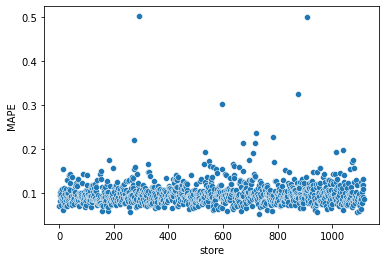

In [237]:
sns.scatterplot( x='store', y='MAPE', data=df92 );

###9.2. Total performance

In [240]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x:np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93


,Scenario,Values
0,predictions,"R$282,299,008.00"
1,worst_scenario,"R$281,534,569.10"
2,best_scenario,"R$283,063,437.29"


###9.3. Machine learning performance

In [241]:
# Criando duas colunas
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

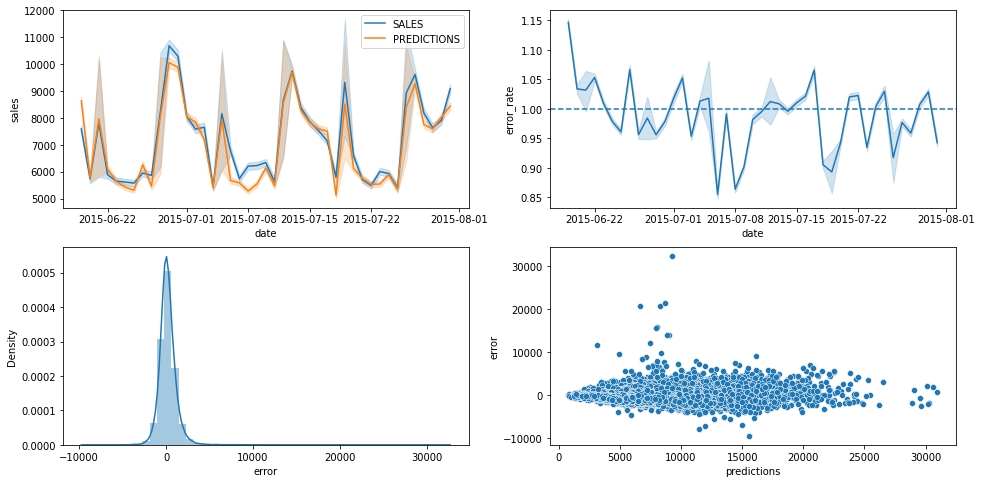

In [243]:
# grafico

plt.figure(figsize=(16, 8))
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] );

Observação: a etapa seguinte será colocar o modelo em produção (deploy model to production)